## Read Files

In [72]:
import pandas as pd
import os

# Files to use for the analysis

# detected_bugs_file = os.path.join('detected_bugs_3.csv')
folder = os.path.join("results")

projects_ranking_file = os.path.join('jmh-projects-bigquery-fh-201702 - jmh-projects-gh.csv')

top = 25

projects = pd.read_csv(projects_ranking_file, sep=',')


# Normalize columns
projects['xml'] = projects['project'].apply(lambda x: x.split('/')[1] + '.xml')
projects['name'] = projects['project'].apply(lambda x: x.split('/')[1])


In [73]:
# Normalizing the plot colors
COLOR = 'cornflowerblue'
COLOR = 'lightskyblue'
ALPHA = .8

## Remove Projects that could not be analyzed

In [74]:
# Remove projects that could not be analyzed
projects_to_remove = ['jgrapht/jgrapht', 'lemire/RoaringBitmap', 'RoaringBitmap/RoaringBitmap', 
                      'requery/requery', 'Netflix/feign', 'crate/crate', 'real-logic/simple-binary-encoding', 
                      'jbachorik/btrace', 'promeG/TinyPinyin', 'pcollections/pcollections', 'ktoso/sbt-jmh', 
                      'junkdog/artemis-odb', 'fakemongo/fongo', 'graalvm/truffle', 'graalvm/graal-core']

projects = projects[~projects['project'].isin(projects_to_remove)] # jgrapht

top_projects = projects.sort_values(by=['watchers', 'stars', 'forks'], ascending=False)

### Remove Forked Projects

In [75]:
non_duplicated_projects = top_projects[top_projects.forked == False]
print('Original Set containing %d projects' % len(top_projects))
print('Non-forked projects containing %d projects' % len(non_duplicated_projects))

Original Set containing 824 projects
Non-forked projects containing 506 projects


## Analyze the bugs based on the Type reported

In [76]:
from collections import Counter
import xml.etree.ElementTree as ET

def analyzeBugTypes(df):
    
    try:
    
        tree = ET.parse(os.path.join(folder, df['xml']))
        root = tree.getroot()

        all_bugs = root.findall('BugInstance')

        bugs_per_type = [] 
        for b in all_bugs:
            bug_type = b.get('type')
            clazz = b.find('Class')
            if clazz and 'generated' not in clazz.get('classname'):
                bugs_per_type.append(bug_type)

        # Count bugs per type
        bugs = Counter(bugs_per_type)
        for key, value in bugs.items():
            df[key] = value
    
    except FileNotFoundError:
        pass
    
    return df

analyzed = non_duplicated_projects.apply(analyzeBugTypes, axis=1)
analyzed = analyzed.fillna(0)
analyzed = analyzed.set_index('name')
analyzed = analyzed[analyzed['JMH_BENCHMARK_METHOD_FOUND'] > 0]

## Generate Latex

In [77]:
columns_to_export = [
   'stars',
  # 'forks',
   # 'subscribers',
    'JMH_BENCHMARK_METHOD_FOUND',
    'JMH_FIXTURE_USING_INVOCATION_SCOPE',
#     'JMH_FIXTURE_USING_INVOCATION_SCOPE_rel',
    #'JMH_IGNORED_METHOD_RETURN',
#     'JMH_IGNORED_METHOD_RETURN_rel',
  #  'JMH_LOOP_INSIDE_BENCHMARK',
#     'JMH_LOOP_INSIDE_BENCHMARK_rel',
    #'JMH_STATE_FINAL_FIELD',
#     'JMH_STATE_FINAL_FIELD_rel',
    'JMH_NOTFORKED_BENCHMARK',
#     'JMH_NOTFORKED_BENCHMARK_rel',
    'JMH_BENCHMARKMODE_SINGLESHOT',
#     'JMH_BENCHMARKMODE_SINGLESHOT_rel'
    'JMH_UNSINKED_VARIABLE',
   # 'JMH_DEAD_STORE_VARIABLE',
    'JMH_IGNORED_STATIC_METHOD_RETURN',
    'JMH_IGNORED_STATIC_PRIMITIVE_METHOD_RETURN',
    'JMH_STATE_FINAL_PRIMITIVE',
    'JMH_UNSAFELOOP_INSIDE_BENCHMARK',
    #'JMH_STATE_FINAL_STATIC_PRIMITIVE',
]


bug_type_dict = {
    'stars': 'Stars',
    'forks': 'Forks',
    'subscribers': 'Subs',
    'JMH_BENCHMARK_METHOD_FOUND': 'Benchs',
    'JMH_FIXTURE_USING_INVOCATION_SCOPE': 'INVO',
#     'JMH_FIXTURE_USING_INVOCATION_SCOPE_rel': 'INVO %',
    'JMH_IGNORED_METHOD_RETURN': 'RETU',
#     'JMH_IGNORED_METHOD_RETURN_rel': 'RETU %',
    'JMH_UNSAFELOOP_INSIDE_BENCHMARK': 'LOOP',
#     'JMH_LOOP_INSIDE_BENCHMARK_rel': 'LOOP %',
    'JMH_STATE_FINAL_FIELD': 'FINA',
#     'JMH_STATE_FINAL_FIELD_rel': 'FINA %',
    'JMH_NOTFORKED_BENCHMARK': 'FORK',
#     'JMH_NOTFORKED_BENCHMARK_rel': 'FORK %',
    'JMH_BENCHMARKMODE_SINGLESHOT': 'SING',
#     'JMH_BENCHMARKMODE_SINGLESHOT_rel': 'SING %'
    'JMH_UNSINKED_VARIABLE': 'UNSINK',
 #   'JMH_DEAD_STORE_VARIABLE': 'DEAD',
    'JMH_IGNORED_STATIC_METHOD_RETURN': 'STAT',
    'JMH_IGNORED_STATIC_PRIMITIVE_METHOD_RETURN': 'STAT2',
    'JMH_STATE_FINAL_PRIMITIVE': 'FINA',
    
}

analyzed = analyzed[columns_to_export]
analyzed = analyzed.rename(columns=bug_type_dict)



In [79]:
stat2 = analyzed[analyzed['STAT2'] > 0]
stat2

,Stars,Benchs,INVO,FORK,SING,UNSINK,STAT,STAT2,FINA,LOOP
name,,,,,,,,,,
caffeine,2414,38.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0
gs-collections,1652,451.0,0.0,0.0,0.0,85.0,0.0,13.0,0.0,0.0
logging-log4j2,256,346.0,0.0,0.0,5.0,19.0,0.0,5.0,4.0,6.0
oopsla15-artifact,16,213.0,13.0,3.0,5.0,5.0,0.0,2.0,2.0,1.0


In [8]:
# Consolidate both STAT 
analyzed['STAT'] = analyzed['STAT'] + analyzed['STAT2'] 
analyzed = analyzed.drop(['STAT2'], axis=1)

latex = analyzed[:top]
latex = latex.fillna('')
latex = latex.replace({0: ''})

print(latex.to_latex())

\begin{tabular}{lrllllllll}
\toprule
{} &  Stars & Benchs & INVO & FORK & SING & UNSINK & STAT & FINA & LOOP \\
name                     &        &        &      &      &      &        &      &      &      \\
\midrule
RxJava                   &  23558 &    215 &      &      &      &        &      &      &      \\
netty                    &   9746 &    159 &    2 &      &      &     21 &   10 &    2 &   14 \\
zipkin                   &   5627 &     74 &      &      &      &      1 &      &      &      \\
druid                    &   4743 &    148 &    2 &      &      &     86 &      &    1 &   11 \\
okio                     &   3703 &     19 &    1 &      &      &        &      &      &      \\
grpc-java                &   2631 &      3 &      &      &      &      1 &      &      &      \\
caffeine                 &   2414 &     38 &      &      &      &      3 &    1 &      &      \\
h2o-3                    &   1943 &     18 &   10 &      &      &      1 &      &      &    6 \\
gs-col

In [9]:
anti_patterns = ['INVO', 'FORK', 'SING', 'UNSINK', 'STAT', 'FINA', 'LOOP']

def anti_pattern_category_analysis(df):
    cat = 0
    count = 0
    for ap in anti_patterns:
        if df[ap] > 0:
            cat = cat + 1
            count = count + df[ap]
    df['# of AP'] = count
    df['# of Categories'] = cat
    return df
    
df = analyzed.apply(anti_pattern_category_analysis, axis=1)
print('Analyzed Projects containing %d' % len(df))

Analyzed Projects containing 133


### Zero Anti-Patterns Found

### Project Distribution Analysis

Anti-patterns category distribution across different projects.

In [10]:
counts = df['# of Categories'].value_counts()
print(counts.to_latex())

\begin{tabular}{lr}
\toprule
{} &  \# of Categories \\
\midrule
0 &               64 \\
1 &               39 \\
2 &               14 \\
3 &               10 \\
5 &                3 \\
4 &                2 \\
7 &                1 \\
\bottomrule
\end{tabular}



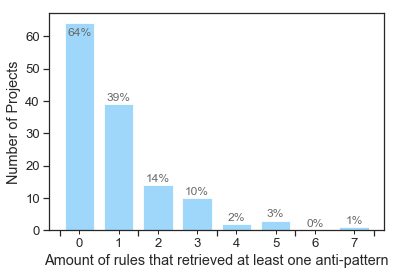

In [48]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sns.set(font_scale=1.2)
plt.figure(figsize=(6,4))
sns.set_style("ticks")

ax = sns.distplot(df['# of Categories'], kde=False, bins=range(0,9), color=COLOR, 
             hist_kws={'rwidth':0.75, 'alpha':ALPHA})

ax.set(xlabel='Amount of rules that retrieved at least one anti-pattern', ylabel='Number of Projects',)

# Annotate Bars
for p in ax.patches:
    if p.get_height() > 50:
        offset = -3
    else:
        offset = +2
    ax.annotate("%.0f%%" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height() + offset),
         ha='center', va='center', rotation=0, xytext=(0, 0), textcoords='offset points',fontsize=12, color='dimgray')  #vertical bars


# Hide major tick labels
ax.xaxis.set_major_formatter(ticker.NullFormatter())

# Centralize minor tick labels
ax.xaxis.set_minor_locator(ticker.FixedLocator([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5]))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(['0','1','2','3','4','5','6','7', '']))

plt.savefig(os.path.join(folder, '..', 'figs', 'projects-rules-ditribution.pdf'))

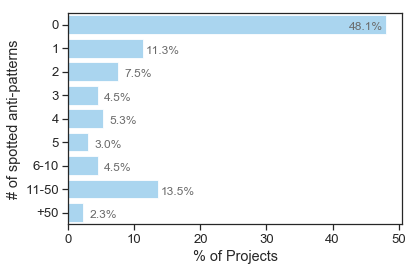

In [68]:
%matplotlib inline
sns.set(font_scale=1.2)
sns.set_style("ticks")

bins = [-1,0,1,2,3,4,5,10,50,111]

plt.figure(figsize=(6,4))

clrs = 'colorblind'
clrs = 'Blues'

distribution = pd.cut(df['# of AP'], bins=bins).value_counts()
distribution = distribution / 133 * 100
distribution = distribution[distribution > 0]
ax = sns.barplot(y=distribution.index, x=distribution, color=COLOR, alpha=ALPHA)

for p in ax.patches:
    if p.get_width() > 40:
        offset = -3
    else:
        offset = +3
    ax.annotate("%.1f%%" % p.get_width(), (p.get_x() + p.get_width() + offset, p.get_y() + .5),
         ha='center', va='center', rotation=0, xytext=(0, 0), textcoords='offset points',fontsize=12, color='dimgray')  #vertical bars

ax.yaxis.set_major_formatter(ticker.FixedFormatter(['0','1','2','3','4','5','6-10','11-50','+50']))
ax.set(ylabel='# of spotted anti-patterns', xlabel='% of Projects',)

plt.tight_layout()

plt.savefig(os.path.join(folder, '..', 'figs', 'projects-ap-ditribution.pdf'))

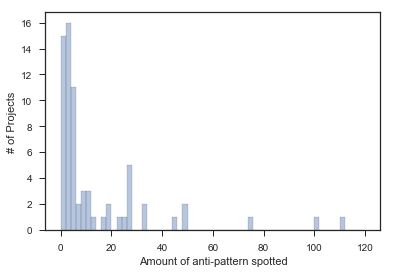

In [111]:
%matplotlib inline
sns.set(font_scale=1)
sns.set_style("ticks")

p = df[df['# of AP'] > 0]
plt.clf()

ax = sns.distplot(p['# of AP'], kde=False, hist=True, bins=range(0,122, 2),
             hist_kws={'edgecolor':'black', 'alpha':.4})

ax.set(xlabel='Amount of anti-pattern spotted', ylabel='# of Projects',)

plt.savefig(os.path.join(folder, '..', 'figs', 'projects-ap-ditribution-2.pdf'))

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


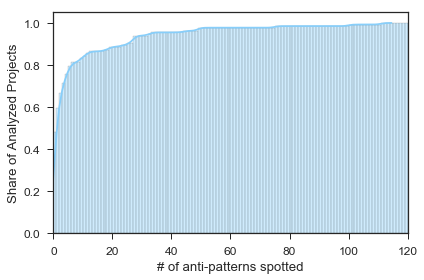

In [225]:
%matplotlib inline

ax = sns.distplot(df['# of AP'], kde=True, bins=range(0,122), color=COLOR,
             hist_kws={'edgecolor':'black', 'cumulative':True},
             kde_kws={'cumulative': True})

plt.xlim([0,120])
ax.set(xlabel='# of anti-patterns spotted', ylabel='Share of Analyzed Projects',)

plt.savefig(os.path.join(folder, '..', 'figs', 'projects-ap-ditribution-cum.pdf'))

### Analysis per Category of Anti-pattern

In [85]:
category_df = pd.DataFrame(columns=['Total', '# of Projects'])

pd.options.display.float_format = '{:.2f}'.format

for ap in anti_patterns:
    total = df[ap].sum()
    projects = len(df[df[ap] > 0])
    category_df.loc[ap] = [total, projects]
    
category_df['% of Projects'] = category_df['# of Projects'] / len(df) * 100

#pd.options.display.float_format = '{:.0f}'.format
    
print(category_df.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Total &  \# of Projects &  \% of Projects \\
\midrule
INVO   &  84.00 &          11.00 &           8.27 \\
FORK   &   7.00 &           3.00 &           2.26 \\
SING   &  55.00 &          11.00 &           8.27 \\
UNSINK & 461.00 &          57.00 &          42.86 \\
STAT   &  74.00 &          12.00 &           9.02 \\
FINA   &  42.00 &          13.00 &           9.77 \\
LOOP   & 193.00 &          20.00 &          15.04 \\
\bottomrule
\end{tabular}



### Selected Projects

In [46]:
selected_projects = [
    'netty',
    'druid',
    'h2o-3',
    'pgdbc',
    'oopsla15-artifact',
    'benchmark-arraycopy',
    'logging-log4j2',
    'caffeine',
    'gs-collections',
    'hppc'
]

df_selected = analyzed[analyzed.index.isin(selected_projects)]
pd.options.display.float_format = '{:2.0f}'.format
df_selected = df_selected[anti_patterns].apply(pd.to_numeric)

print(df_selected[anti_patterns].to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  INVO &  FORK &  SING &  UNSINK &  STAT &  STAT2 &  FINA &  LOOP \\
name                &       &       &       &         &       &        &       &       \\
\midrule
netty               &     2 &     0 &     0 &      21 &    10 &      0 &     2 &    14 \\
druid               &     2 &     0 &     0 &      86 &     0 &      0 &     1 &    11 \\
caffeine            &     0 &     0 &     0 &       3 &     0 &      1 &     0 &     0 \\
h2o-3               &    10 &     0 &     0 &       1 &     0 &      0 &     0 &     6 \\
gs-collections      &     0 &     0 &     0 &      85 &     0 &     13 &     0 &     0 \\
hppc                &     0 &     0 &     3 &       0 &     0 &      0 &     0 &     0 \\
logging-log4j2      &     0 &     0 &     5 &      19 &     0 &      5 &     4 &     6 \\
oopsla15-artifact   &    13 &     3 &     5 &       5 &     0 &      2 &     2 &     1 \\
netty               &     2 &     0 &     0 &      21 &    10 &      0 &

In [47]:
selected = pd.DataFrame(columns=['#1', '#2', '#3'])

for ap in anti_patterns: 
    p = analyzed[analyzed[ap] > 1] # Filter unique cases
    selected.loc[ap] = p[:3].index.values
    
print(selected.to_latex())

\begin{tabular}{llll}
\toprule
{} &              \#1 &                 \#2 &                        \#3 \\
\midrule
INVO   &           netty &              druid &                     h2o-3 \\
FORK   &          pgjdbc &  oopsla15-artifact &       benchmark-arraycopy \\
SING   &            hppc &     logging-log4j2 &                     xodus \\
UNSINK &           netty &              druid &                  caffeine \\
STAT   &           netty &                geo &  reactive-streams-commons \\
STAT2  &  gs-collections &     logging-log4j2 &         oopsla15-artifact \\
FINA   &           netty &     logging-log4j2 &               jmh-samples \\
LOOP   &           netty &              druid &                     h2o-3 \\
\bottomrule
\end{tabular}



### Correlation between # Benchmarks and Amount of Antipatterns found

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0.7128467205681948, 6.329768902083779e-22)

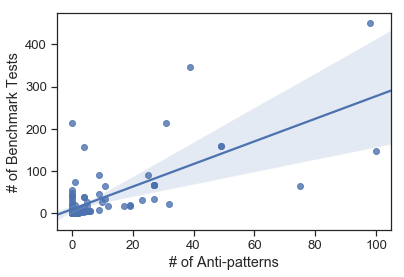

In [71]:
from scipy import stats

all_antipatterns = ['INVO', 'FORK', 'SING', 'UNSINK', 'LOOP', 'STAT', 'FINA']

df['# of Anti-patterns'] = df[all_antipatterns].apply(sum, axis=1)

ax = sns.regplot(x="Sum", y="Benchs", data=df)
ax.set(xlabel='# of Anti-patterns', ylabel='# of Benchmark Tests')
plt.savefig(os.path.join(folder, '..', 'figs', 'correlation-bench-ap.pdf'))

stats.pearsonr(df['Benchs'].values, df['# of Anti-patterns'].values)

